speaker verification project

In this project, I implemented a speaker verification model on the STM32L4R9I-DISCOVERY evaluation board, which has a memory capacity of 2MB FLASH and 640KB RAM. I evaluated two models: version of ECAPA-TDNN and version of ResNet.

This notebook focuses on a modified version of the ResNet model. While it is still based on the original architecture, it is significantly altered in terms of design and size to meet the constraints of the STM32L4R9I-DISCOVERY board and to be compatible with PyTorch quantization.


This project consists of five notebooks:

Gold standard ECAPA 

Distillation tiny version ECAPA 

QAT tiny version ECAPA 

Gold standard Resnet 

Tiny version Resnet (this notebook)

Some functions were adapted from the following sources:
1. https://github.com/TaoRuijie/ECAPA-TDNN/tree/main


   which based on the following projects:
   
1. https://github.com/clovaai/voxceleb_trainer/issues/86
2. https://github.com/lawlict/ECAPA-TDNN/blob/master/ecapa_tdnn.py
3. https://github.com/speechbrain/speechbrain/blob/96077e9a1afff89d3f5ff47cab4bca0202770e4f/speechbrain/lobes/models/ 
   ECAPA_TDNN.py
   
   and:
2. https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py

Importing packegs 

In [7]:
import math, torch, torchaudio, os, numpy, glob, random, soundfile, sys, tqdm, time
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from operator import itemgetter
from scipy import signal
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchaudio import transforms
from torchsummary import summary
from IPython.display import Audio
import torch.nn.utils.prune as prune
import torch.onnx
import onnx
from torch.nn.parameter import Parameter
import onnxruntime as ort
import copy

Define the device that will run the model.

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

The next cell contains the model architecture.

In [9]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=110, stride=2)

        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(110*ResBlock.expansion, num_classes)

        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        


In [10]:
model = ResNet(Bottleneck, [1,1], num_classes=152, num_channels=1).to(device)

Description of the model.

In [11]:
summary(model, input_size=(1,80,30), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 42, 17]             576
       BatchNorm2d-2            [1, 64, 42, 17]             128
              ReLU-3            [1, 64, 42, 17]               0
         MaxPool2d-4             [1, 64, 21, 9]               0
            Conv2d-5             [1, 64, 21, 9]           4,160
       BatchNorm2d-6             [1, 64, 21, 9]             128
              ReLU-7             [1, 64, 21, 9]               0
            Conv2d-8             [1, 64, 21, 9]          36,928
       BatchNorm2d-9             [1, 64, 21, 9]             128
             ReLU-10             [1, 64, 21, 9]               0
           Conv2d-11            [1, 256, 21, 9]          16,640
      BatchNorm2d-12            [1, 256, 21, 9]             512
           Conv2d-13            [1, 256, 21, 9]          16,640
      BatchNorm2d-14            [1, 256

The following cell includes some utility functions.

In [12]:
def tuneThresholdfromScore(scores, labels, target_fa, target_fr = None):
	
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr
    tunedThreshold = [];
    if target_fr:
        for tfr in target_fr:
            idx = numpy.nanargmin(numpy.absolute((tfr - fnr)))
            tunedThreshold.append([thresholds[idx], fpr[idx], fnr[idx]])
    for tfa in target_fa:
        idx = numpy.nanargmin(numpy.absolute((tfa - fpr))) # numpy.where(fpr<=tfa)[0][-1]
        tunedThreshold.append([thresholds[idx], fpr[idx], fnr[idx]])
    idxE = numpy.nanargmin(numpy.absolute((fnr - fpr)))
    eer  = max(fpr[idxE],fnr[idxE])*100
    eer_threshold = thresholds[idxE]
    
    return tunedThreshold, eer, fpr, fnr, eer_threshold

# Creates a list of false-negative rates, a list of false-positive rates
# and a list of decision thresholds that give those error-rates.
def ComputeErrorRates(scores, labels):

      # Sort the scores from smallest to largest, and also get the corresponding
      # indexes of the sorted scores.  We will treat the sorted scores as the
      # thresholds at which the the error-rates are evaluated.
      sorted_indexes, thresholds = zip(*sorted(
          [(index, threshold) for index, threshold in enumerate(scores)],
          key=itemgetter(1)))
      sorted_labels = []
      labels = [labels[i] for i in sorted_indexes]
      fnrs = []
      fprs = []

      # At the end of this loop, fnrs[i] is the number of errors made by
      # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
      # is the total number of times that we have correctly accepted scores
      # greater than thresholds[i].
      for i in range(0, len(labels)):
          if i == 0:
              fnrs.append(labels[i])
              fprs.append(1 - labels[i])
          else:
              fnrs.append(fnrs[i-1] + labels[i])
              fprs.append(fprs[i-1] + 1 - labels[i])
      fnrs_norm = sum(labels)
      fprs_norm = len(labels) - fnrs_norm

      # Now divide by the total number of false negative errors to
      # obtain the false positive rates across all thresholds
      fnrs = [x / float(fnrs_norm) for x in fnrs]

      # Divide by the total number of corret positives to get the
      # true positive rate.  Subtract these quantities from 1 to
      # get the false positive rates.
      fprs = [1 - x / float(fprs_norm) for x in fprs]
      return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

def Accuracy(predictions, targets):

    # Get the predicted class (index of max logit)
    _, predicted = torch.max(predictions, 1)
    
    # Check if the predicted classes match the targets
    correct = (predicted == targets).float()  # Convert to float for averaging
    
    # Calculate accuracy
    accuracy = correct.sum() / targets.size(0) * 100.0  # Convert to percentage

    return accuracy.item()  


def MelSpectrogram(audio):

    # this function create the melspcetrogram feature.
    # the parametres of the melspectrogram are described here.
    # after the spectrogram is created we apllyed a log function.
    
    eps = 2**-24
    
    MelSpec = librosa.feature.melspectrogram(y=audio, sr=16000, n_fft=1024, hop_length=512, fmin=20, fmax=8000, win_length=1024,norm=None, window='hamming',n_mels=80, center=False, power=2.0)

    dB_MelSpec = numpy.log(MelSpec + eps)
   
    MelSpec_torch = torch.FloatTensor(dB_MelSpec)

    return MelSpec_torch


def spectro_augment(spec, max_mask_pct=0.05, n_freq_masks=1, n_time_masks=1):

    # we create an augmentation of masking in the time and frequncy domain.
    
    mask_value = spec.mean()
        
    aug_spec = spec
    
    freq_mask_param = max_mask_pct * aug_spec.shape[1]
    
    for i in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
    
    time_mask_param = max_mask_pct * aug_spec.shape[2]
    
    for i in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

def pre_emphasis(signal):

    # pre-emphasis function is apllyed here.
    
    emphasized_signal = numpy.append(signal[0], signal[1:] - 0.97 * signal[:-1])
    
    emphasized_signal = numpy.stack([emphasized_signal],axis=0)
    
    return emphasized_signal

def MelSpecNorm(spec):

    # this function normelized the melspectrogram in a way it calaculated the mean and the std on each chanell (row)  

    CONST = 1e-5
   
    Spec_mean = torch.zeros((spec.shape[0], spec.shape[1]), dtype=spec.dtype, device=spec.device)
    Spec_std = torch.zeros((spec.shape[0], spec.shape[1]), dtype=spec.dtype, device=spec.device)
    
    for i in range(spec.shape[0]):
        
        Spec_mean[i,:] = torch.mean(spec[i, :, : spec.shape[2]], dim=1)
        Spec_std[i,:] = torch.std(spec[i, : , : spec.shape[2]], dim=1)
    
    
    MelSpecNorm = (spec - Spec_mean.unsqueeze(2)) / (Spec_std.unsqueeze(2) + CONST)
    
    
    return MelSpecNorm

The next cell contains the loss function.

In [13]:
class AAMsoftmax(nn.Module):
    def __init__(self, n_class, m, s_m):
        
        super(AAMsoftmax, self).__init__()
        self.m = m
        self.s = s_m
        self.weight = torch.nn.Parameter(torch.FloatTensor(n_class, 152), requires_grad=True)
        self.ce = nn.CrossEntropyLoss()
        nn.init.xavier_normal_(self.weight, gain=1)
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, x, label):#label=None
        
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.mul(cosine, cosine)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        
        loss = self.ce(output, label)
        prec = Accuracy(output.detach(), label.detach())

        return loss, prec

DataLoader setup for training.

In [14]:
class train_loader(Dataset):
    
    def __init__(self, train_list, train_path, musan_path, rir_path, num_frames):#, **kwargs):
        self.train_path = train_path
        self.num_frames = num_frames
    
    
        # Load and configure augmentation files
        
        self.noisesnr = {'noise':[0,15],'speech':[13,20],'music':[5,15]}
        self.numnoise = {'noise':[1,1], 'speech':[3,8], 'music':[1,1]}
        self.noiselist = {}
        augment_files   = glob.glob(os.path.join(musan_path,'*/*/*.wav'))
        for file in augment_files:
            if file.split('/')[-3] not in self.noiselist:
                self.noiselist[file.split('/')[-3]] = []
            self.noiselist[file.split('/')[-3]].append(file)
        self.rir_files  = glob.glob(os.path.join(rir_path,'*/*/*.wav'))
        # Load data & labels
        self.data_list  = []
        self.data_label = []
        lines = open(train_list).read().splitlines()
        dictkeys = list(set([x.split()[0] for x in lines]))
        dictkeys.sort()
        dictkeys = { key : ii for ii, key in enumerate(dictkeys) }
        for index, line in enumerate(lines):
            speaker_label = dictkeys[line.split()[0]]
            file_name     = os.path.join(train_path, line.split()[1])
            self.data_label.append(speaker_label)
            self.data_list.append(file_name)

    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        # Read the utterance and randomly select the segment
  
        audio, sr = librosa.load(self.data_list[index], sr=16000)
        length = self.num_frames * 160 
        if audio.shape[0] <= length:
            shortage = length - audio.shape[0]
            audio = numpy.pad(audio, (0, shortage), 'wrap')
        start_frame = numpy.int64(random.random()*(audio.shape[0]-length))
        audio = audio[start_frame:start_frame + length]
        audio_clean = numpy.stack([audio],axis=0)
        # Data Augmentation
        augclass = ['Original', ' Reverberation', 'Babble', 'Music','Noise', 'Television noise']
        
        # in order to speed up the training time I trained it without augmentaions most of the epochs by changing augtype=0
        augtype = 0
        #augtype = random.randint(0,5)
        
        if augtype == 0:   # Original
            audio = audio_clean
        elif augtype == 1: # Reverberation
            audio = self.add_rev(audio_clean,)
        elif augtype == 2: # Babble
            audio = self.add_noise(audio_clean, noisecat='speech')
        elif augtype == 3: # Music
            audio = self.add_noise(audio_clean, noisecat='music')
        elif augtype == 4: # Noise
            audio = self.add_noise(audio_clean, noisecat='noise')
        elif augtype == 5: # Television noise
            audio = self.add_noise(audio_clean, noisecat='speech')
            audio = self.add_noise(audio_clean, noisecat='music')
    
        audio_pre_emphasis = pre_emphasis(audio)

        MelSpec = MelSpectrogram(audio_pre_emphasis)
        
        MelSpec_norm = MelSpecNorm(MelSpec)
        
        Mel_Spec_aug = spectro_augment(MelSpec_norm)
        
                
        return Mel_Spec_aug, self.data_label[index], audio_pre_emphasis

    
    
    def add_rev(self, audio):
        rir_file    = random.choice(self.rir_files)
        rir, sr     = soundfile.read(rir_file)
        rir         = numpy.expand_dims(rir.astype(numpy.float32),0)
        rir         = rir / numpy.sqrt(numpy.sum(rir**2))
        return signal.convolve(audio, rir, mode='full')[:,:self.num_frames * 160] 
    
    def add_noise(self, audio, noisecat):
        clean_db    = 10 * numpy.log10(numpy.mean(audio ** 2)+1e-4) 
        numnoise_1    = self.numnoise[noisecat]
        noiselist   = random.sample(self.noiselist[noisecat], random.randint(numnoise_1[0],numnoise_1[1]))
        noises = []
        for noise in noiselist:
            noiseaudio, sr = soundfile.read(noise)
            length = self.num_frames * 160
            if noiseaudio.shape[0] <= length:
                shortage = length - noiseaudio.shape[0]
                noiseaudio = numpy.pad(noiseaudio, (0, shortage), 'wrap')
            start_frame = numpy.int64(random.random()*(noiseaudio.shape[0]-length))
            noiseaudio = noiseaudio[start_frame:start_frame + length]
            noiseaudio = numpy.stack([noiseaudio],axis=0)
            noise_db = 10 * numpy.log10(numpy.mean(noiseaudio ** 2)+1e-4) 
            noisesnr   = random.uniform(self.noisesnr[noisecat][0],self.noisesnr[noisecat][1])
            noises.append(numpy.sqrt(10 ** ((clean_db - noise_db - noisesnr) / 10)) * noiseaudio)
        noise = numpy.sum(numpy.concatenate(noises,axis=0),axis=0,keepdims=True)
        return noise + audio
    

The next cell is used to train the model and evaluate its performance.

In [15]:
class RESNETModel(nn.Module):
    def __init__(self, lr, lr_decay, n_class, m, s_m, test_step): 
        super(RESNETModel, self).__init__()
        self.speaker_encoder = ResNet(Bottleneck, [1,1], num_classes=152, num_channels=1).to(device)
        ## Classifier
        self.speaker_loss    = AAMsoftmax(n_class = n_class, m = m, s_m = s_m).to(device)   
        self.optim           = torch.optim.Adam(self.parameters(), lr = lr, weight_decay=2e-5) 
        self.scheduler       = torch.optim.lr_scheduler.StepLR(self.optim, step_size = test_step, gamma=lr_decay)
   
    def train_network(self, epoch, loader):
        self.train()
        ## Update the learning rate based on the current epcoh
        
        index, top1, loss = 0, 0, 0
        lr = self.optim.param_groups[0]['lr']
        for num, (data, labels, _ ) in enumerate(loader): 
            self.zero_grad()
            labels            = torch.LongTensor(labels).to(device)   
            speaker_embedding = self.speaker_encoder.forward(data.to(device)) 
            nloss, prec       = self.speaker_loss.forward(speaker_embedding, labels)			
            nloss.backward()
            self.optim.step()
            index += len(labels)
            top1 += prec
            loss += nloss.detach().cpu().numpy()
            sys.stderr.write(time.strftime("%m-%d %H:%M:%S") + \
                             " [%2d] Lr: %5f, Training: %.2f%%, "    %(epoch, lr, 100 * ((num+1) / loader.__len__())) + \
                             " Loss: %.5f, ACC: %2.2f%% \r"        %(loss/(num+1), top1/index*len(labels)))
            sys.stderr.flush()
        self.scheduler.step()
        sys.stdout.write("\n")
        return loss/num, lr, top1/index*len(labels)

    def eval_network(self, eval_list, eval_path, num_frames):
        self.eval()
        files = []
        embeddings = {}
        lines = open(eval_list).read().splitlines()
        for line in lines:
            files.append(line.split()[1])
            files.append(line.split()[2])
        setfiles = list(set(files))
        setfiles.sort()
        
        for idx, file in tqdm.tqdm(enumerate(setfiles), total = len(setfiles)):
            
            audio, sr = librosa.load(os.path.join(eval_path, file), sr=16000)
            audio = pre_emphasis(audio).squeeze()
      
            data_1 = audio
            data_1_spec = torch.unsqueeze(MelSpectrogram(data_1),dim=0)
            data_1_spec_norm =  MelSpecNorm(data_1_spec)
            data_1_spec_norm = torch.unsqueeze(data_1_spec_norm,dim=1)

            
            # Spliited utterance matrix
            max_audio = num_frames * 160  
            if audio.shape[0] <= max_audio:
                shortage = max_audio - audio.shape[0]
                audio = numpy.pad(audio, (0, shortage), 'wrap')
            feats = []
            startframe = numpy.linspace(0, audio.shape[0]-max_audio, num=5)
            for asf in startframe:
                feats.append(audio[int(asf):int(asf)+max_audio])
            feats = numpy.stack(feats, axis = 0).astype(numpy.float32)
           
            
            data_2 = feats  
            data_2_spec = MelSpectrogram(data_2)
            data_2_spec_norm =  MelSpecNorm(data_2_spec).squeeze()
            data_2_spec_norm =  torch.unsqueeze(data_2_spec_norm,dim=1)

            # Speaker embeddings
            with torch.no_grad():
                
                embedding_1 = self.speaker_encoder.forward(data_1_spec_norm.to(device))
                embedding_1 = F.normalize(embedding_1, p=2, dim=1)
                embedding_2 = self.speaker_encoder.forward(data_2_spec_norm.to(device))
                embedding_2 = F.normalize(embedding_2, p=2, dim=1)
            embeddings[file] = [embedding_1, embedding_2]

        
        scores, labels  = [], []
        
        for line in lines:			
            embedding_11, embedding_12 = embeddings[line.split()[1]]
            embedding_21, embedding_22 = embeddings[line.split()[2]]

            # Compute the scores
            score_1 = torch.mean(torch.matmul(embedding_11, embedding_21.T))# higher is positive
            score_2 = torch.mean(torch.matmul(embedding_12, embedding_22.T))
            score = (score_1 + score_2) / 2
            score = score.detach().cpu().numpy()
            
            
            scores.append(score)
            labels.append(int(line.split()[0]))
            
        
        # checking if there is any nan in the scores or lables (shouldn't be)
        if numpy.isnan(scores).any():
            
            nan_count = numpy.isnan(scores).sum()
            # Print the number of NaN values
            print(f"Number of NaN values in scores: {nan_count}")
            nan_score = ~numpy.isnan(scores)
            nan_index = numpy.where(~nan_score)
            scores = list(numpy.array(scores)[nan_score])
            labels = numpy.array(labels)
            labels = list(numpy.delete(labels,nan_index))
        
        # Coumpute EER and minDCF
        tunedThreshold, eer, fpr, fnr,eer_threshold = tuneThresholdfromScore(scores, labels, [1, 0.1])
        fnrs, fprs, thresholds = ComputeErrorRates(scores, labels)
        minDCF, min_c_det_threshold = ComputeMinDcf(fnrs, fprs, thresholds, 0.05, 1, 1)
        
        return eer, minDCF,  tunedThreshold, thresholds, min_c_det_threshold, eer_threshold
        
    
    def save_parameters(self, path):
        torch.save(self.state_dict(), path)
        

    
    
    def load_parameters(self, path):
        self_state = self.state_dict()
        loaded_state = torch.load(path, weights_only=True)
        for name, param in loaded_state.items():
            origname = name
            if name not in self_state:
                name = name.replace("module.", "")
                if name not in self_state:
                    print("%s is not in the model."%origname)
                    continue
            if self_state[name].size() != loaded_state[origname].size():
                print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
                continue
            self_state[name].copy_(param)

In [16]:
lr = 0.005        # Learning rate
lr_decay = 0.97   # Learning rate decay every [test_step] epochs
n_class = 1211    # Number of speakers
m = 0.2           # Loss margin in AAM softmax'
s_m = 30          # Loss scale in AAM softmax'
test_step = 1     # test and save every [test_step] epochs
num_frames = 200  # Duration of the input segments, eg: 200 for 2 seconds
max_epoch = 80    # numbers of epochs 
batch_size = 128  # batch size

In [17]:
# paths of the dataset 
# you should change PATH according your folders

train_list = "/PATH/voxceleb1_train_list_new.txt"
train_path = "/PATH/voxceleb1/vox1_dev_wav/wav"

eval_list =  "/PATH/veri_test.txt"
eval_path =  "/PATH/voxceleb1/vox1_test_wav/wav"

musan_path = "/PATH/musan"
rir_path = "/PATH/rirs_noises/RIRS_NOISES/simulated_rirs"


In [18]:
## Define the data loader

trainloader = train_loader(train_list=train_list, train_path=train_path, musan_path=musan_path, rir_path=rir_path, num_frames=num_frames)
trainLoader = DataLoader(trainloader, batch_size, shuffle=True,drop_last=True)


In [19]:
# In order to examine the features and the dataset we load one batch of data

train_batch = iter(trainLoader)
for (data, targets, audio) in train_batch:
    data = torch.squeeze(data.to(device))
    targets = targets.to(device)
    audio = torch.squeeze(audio)
    break

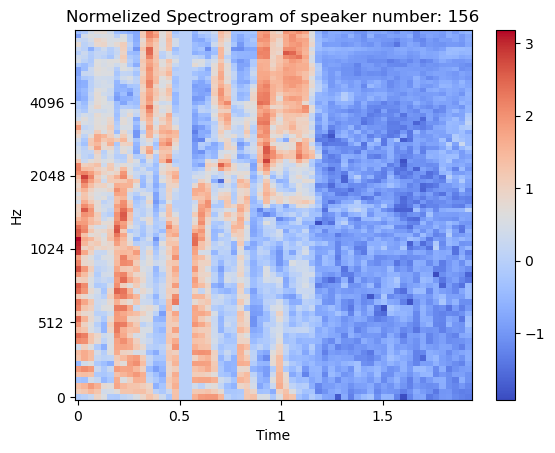

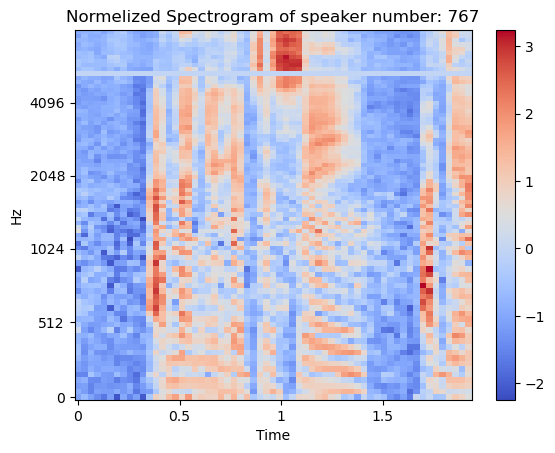

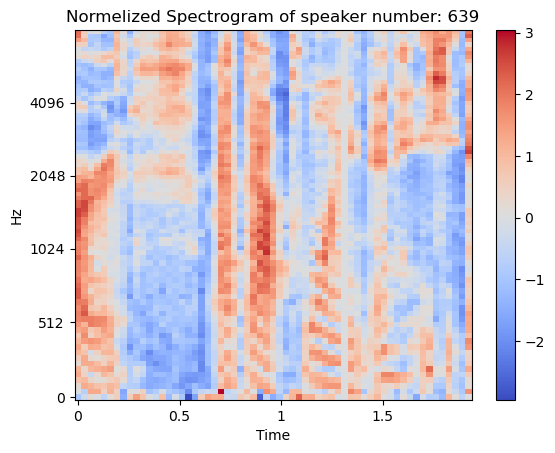

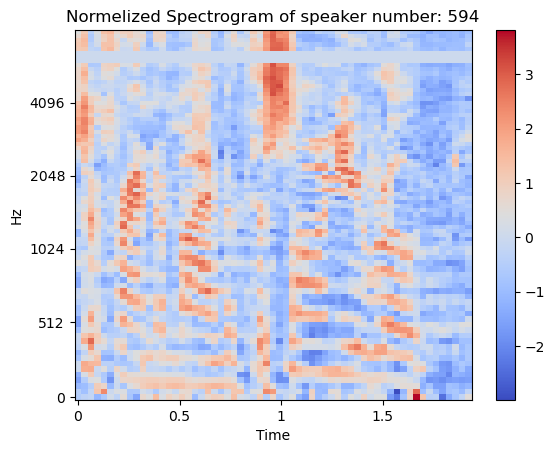

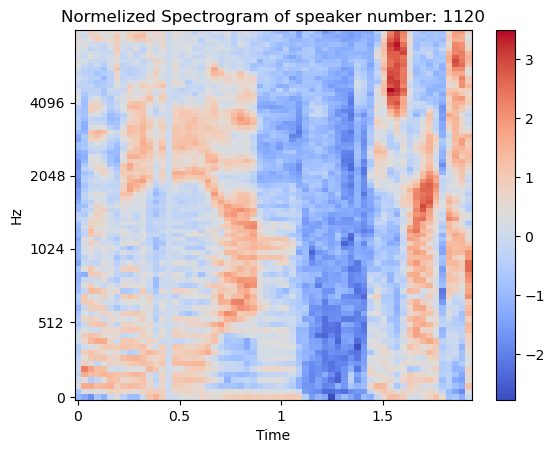

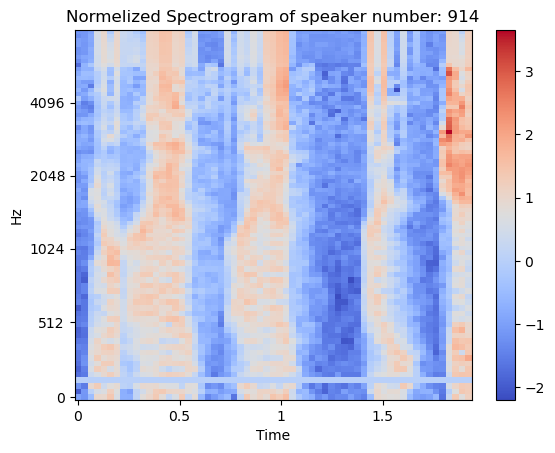

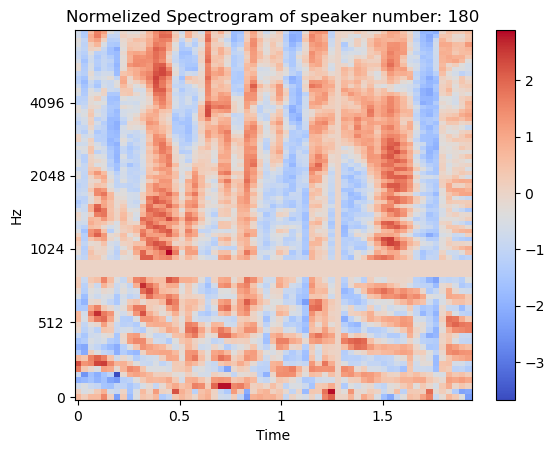

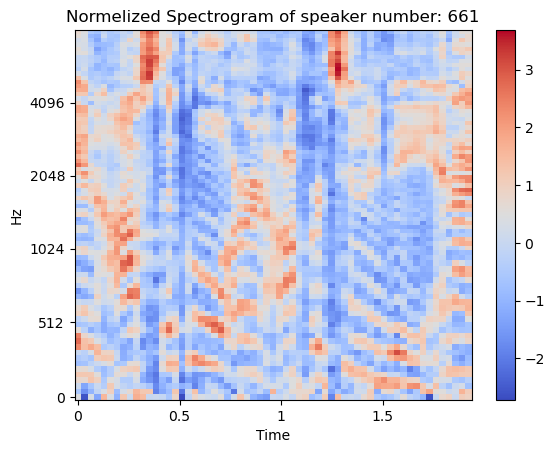

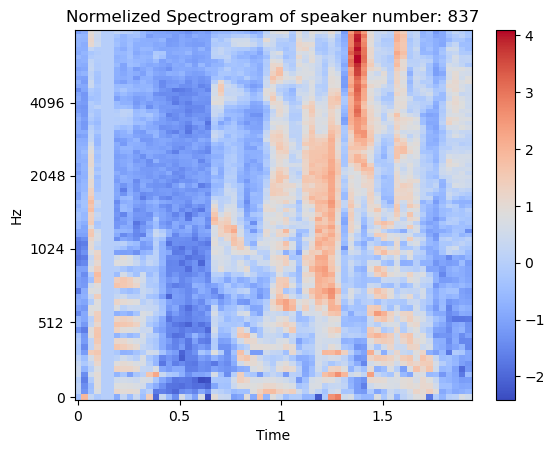

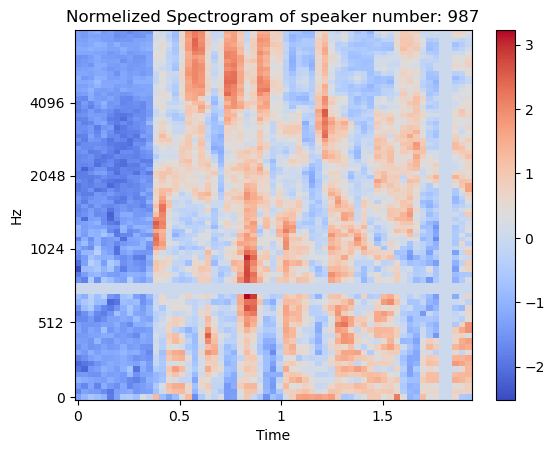

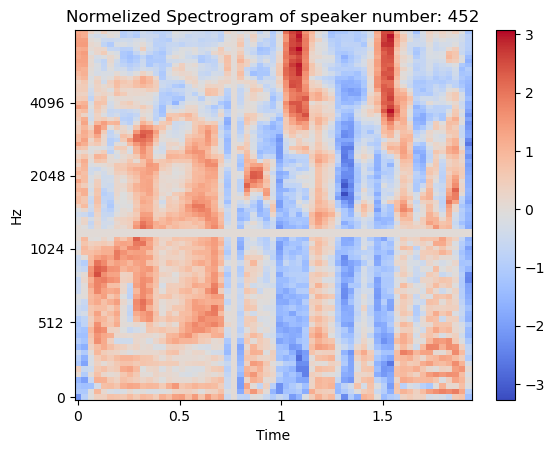

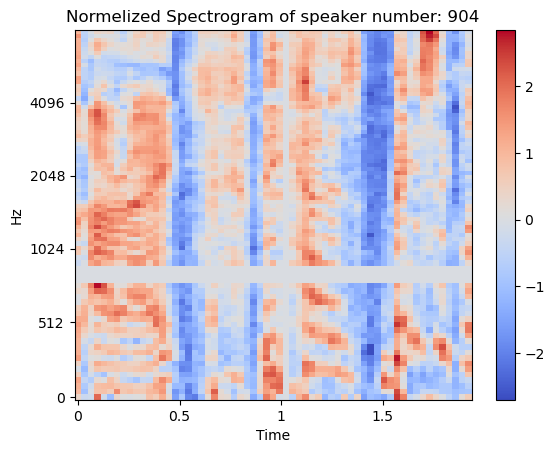

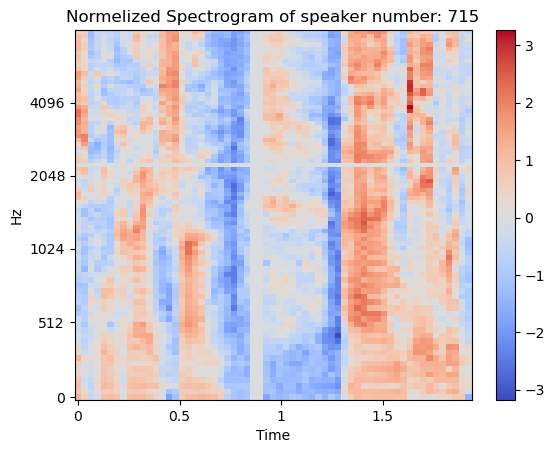

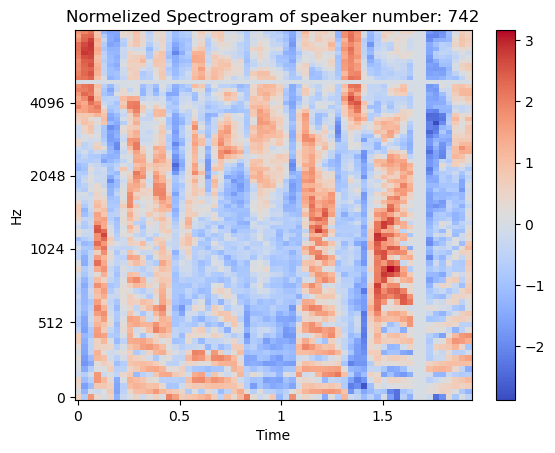

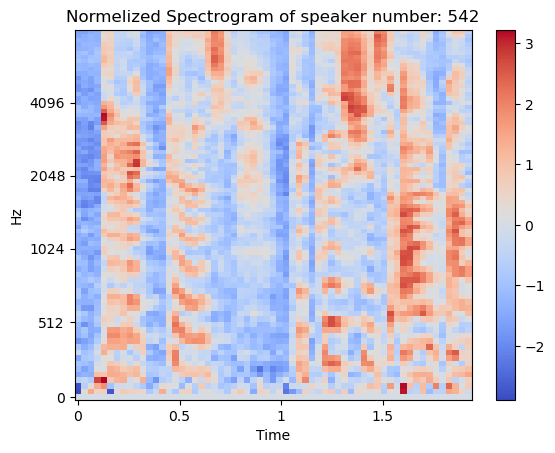

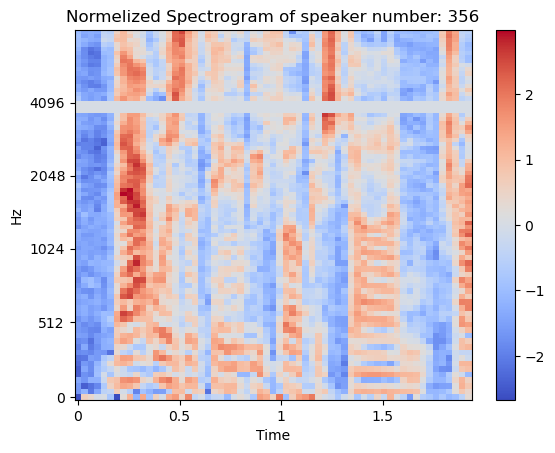

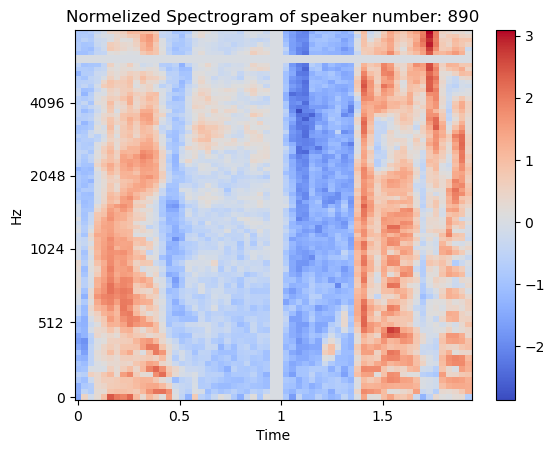

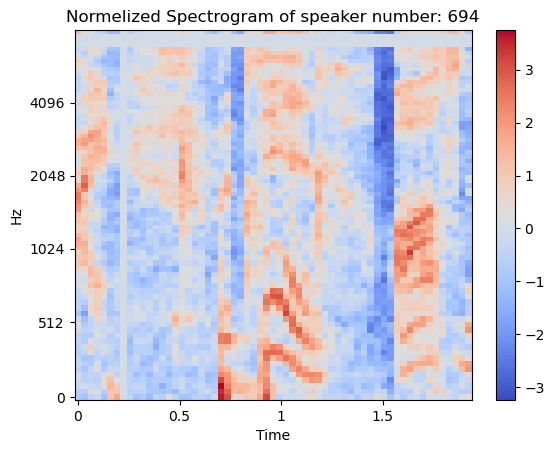

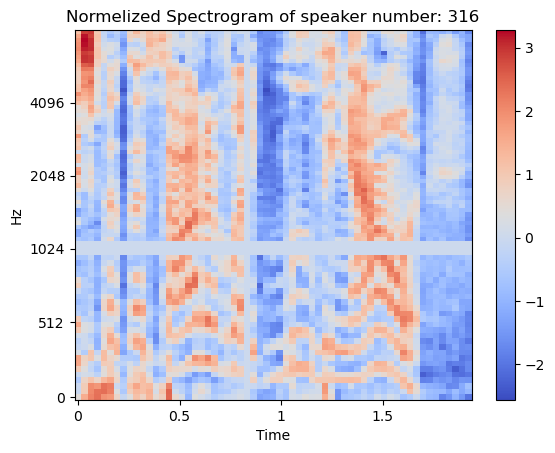

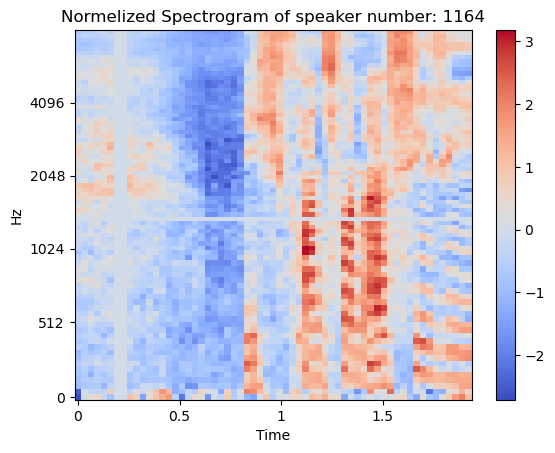

In [21]:
for i in range(20):  

    display(Audio(audio[i], rate=16000))
            
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    img_0 = librosa.display.specshow(data[i].cpu().numpy(), sr=16000, x_axis='time', y_axis='mel', ax=ax, hop_length=512 )
    ax.set(title='Normelized Spectrogram of speaker number: ' + str(targets[i].cpu().numpy()) )
    plt.colorbar(img_0, ax=ax)
    

In [22]:
# Define the folder of saving the student model and loading it if there is one

save_path = "/PATH/Small_version_Resnet"
score_save_path    = os.path.join(save_path, 'score.txt')
score_save_path_new    = os.path.join(save_path, 'score_new.txt')
model_save_path    = os.path.join(save_path, 'model')

## Search for the exist models
modelfiles = glob.glob('%s/model_0*.model'%model_save_path)
modelfiles.sort()
modelfiles = " ".join(modelfiles)

The next cell is used for model evaluation, particularly if there's an initial model and we want to assess its performance.

In [ ]:
# In order to do evaluation we have to change the 'do_eval' to True
do_eval = True

# Only do evaluation, the initial_model is necessary
if do_eval == True:
    
    print("Model %s loaded from previous state!"%modelfiles.split()[-1][-16:-6])
    
    s = RESNETModel(lr=lr,lr_decay=lr_decay,n_class=n_class, m=m, s_m=s_m, test_step=test_step)
    s.load_parameters(modelfiles.split()[-1])
    eer, minDCF,  tunedThreshold, thresholds,min_c_det_threshold, eer_threshold = s.eval_network(eval_list = eval_list, eval_path = eval_path, num_frames=num_frames)
    print("EER %2.2f%%, minDCF %.4f%%, eer_threshold %.4f"%(eer, minDCF, eer_threshold))
    


Traning the model

In [ ]:
# system will try to start from the saved model&epoch

if len(modelfiles) >= 1:
    print("Model %s loaded from previous state!"%modelfiles[-16:-6])
    
    epoch = int(modelfiles[-10:-6]) + 1 
    s = RESNETModel(lr=lr,lr_decay=lr_decay,n_class=n_class, m=m, s_m=s_m, test_step=test_step)

    s.load_parameters(modelfiles.split()[-1])


## Otherwise, system will train from scratch
else:
    epoch = 1
    s = RESNETModel(lr=lr,lr_decay=lr_decay,n_class=n_class, m=m, s_m=s_m, test_step=test_step)

EERs = []

score_file = open(score_save_path, "a+")


while(1):
    ## Training for one epoch
    loss, lr, acc = s.train_network(epoch = epoch, loader = trainLoader)

    ## Evaluation every [test_step] epochs
    if epoch % test_step == 0:
        s.save_parameters(model_save_path + "/model_%04d.model"%epoch)
        eer, minDCF,  tunedThreshold, thresholds,min_c_det_threshold, eer_threshold = s.eval_network(eval_list = eval_list, eval_path = eval_path, num_frames=num_frames)
        EERs.append(eer)
        print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, LR %f, TRAINING LOSS %f, TRAINING ACC %2.2f%%, EER %2.2f%%, bestEER %2.2f%%, minDCF %.4f%%, eer_threshold %.4f "%(epoch,lr, loss, acc, EERs[-1], min(EERs),minDCF, eer_threshold))
        score_file.write("%d epoch, LR %f, TRAINING LOSS %f, TRAINING ACC %2.2f%%, EER %2.2f%%, bestEER %2.2f%%, minDCF %.4f%%, eer_threshold %.4f \n"%(epoch, lr, loss, acc, EERs[-1], min(EERs), minDCF, eer_threshold))
        
        score_file.flush()
  

    if epoch >= max_epoch:
        break
        #quit()

    epoch += 1


The results of the training are shown in the folder 'Small_version_Resnet'. 
After epoch 80 I changed the farme_num to 100.

Exporting the model as ONNX format

In [33]:
dummy_input = data[0].to(device)
dummy_input = dummy_input.unsqueeze(0).unsqueeze(0)

In [34]:
model_filepath_onnx = '/PATH/model_onnx_Small_version_Resnet.onnx'

torch.onnx.export(
    s.speaker_encoder,
    dummy_input,
    model_filepath_onnx,
    input_names=['input'],
    output_names=['output'],)


In [ ]:
print(f"Size of model: {os.path.getsize(model_filepath_onnx)/10**6} Mbytes")

Evaluation of the ONNX Model for Sanity Check

In [36]:
print("Loaded ONNX model")

model_fp32_path = model_filepath_onnx

ort_sess = ort.InferenceSession(model_fp32_path)

Loaded ONNX model


Evaluation of the ONNX model and the original model.

In [37]:
onnx_input = {ort_sess.get_inputs()[0].name: dummy_input.cpu().numpy()}
onnx_output = torch.FloatTensor(ort_sess.run(None, onnx_input)[0])
original_output = s.speaker_encoder.forward(dummy_input).cpu()


In [ ]:
squared_diff = (onnx_output - original_output) ** 2

# Compute the mean of the squared differences

mse = squared_diff.mean()
mse

The performance of the ONNX model is similar to the original one.